# MovieLens Data Analysis

- Student name: Gamze Turan
- Student pace: self paced
- Scheduled project review date/time: 
- Instructor name: Claude Fried
- Blog post URL: https://ginaturan.blogspot.com/2022/08/natural-language-processing-nlp.html 

<img align="center" width="900" height="300" src='Images/MovieLens.png'>

## Overview

Movielens is a website that helps users find movies they will like. It users ratings given by the user to build a custom taste profile of that particular user and then utilizes that information to recommend other movies for the user to watch.

## Business Understanding

<img align="left" width="600" height="300" src='Images/main-screen.png'>

Our goal is to build a variety of recommendation engines and improve upon predictions iteratively so that the end user can be provided with better movie suggestions.

## Data Understanding

The datasets describe ratings and free-text tagging activities from [MovieLens](https://movielens.org/), a movie recommendation service.

  > Source: F. Maxwell Harper and Joseph A. Konstan. 2015.The MovieLens Datasets: History and Context. ACM                              Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872

It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users.

The dataset is distributed among four csv files: `links.csv`, `movies.csv`, `ratings.csv`, `tags.csv`.

In [60]:
# importing necessary libraries
import pandas as pd
import numpy as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from surprise import Dataset
from surprise import Reader
from surprise import SVD, SVDpp
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNWithZScore
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display, clear_output

## Load data

### Movies Data

Movie information is contained in the file movies.csv. Each line of this file after the header row represents one movie, and has the following format:

   > movieId,title,genres

* `movieId`: Unique id for each movie
* `title`: Name of movies followed by their year of release
* `genres`: categories that a movie might fall into separated by `|`

In [61]:
import pandas as pd

In [62]:
# movies data
movies_df = pd.read_csv('Data/movies.csv')
print('Size of movies data:', movies_df.shape)
movies_df.head()

Size of movies data: (9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [63]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Some observations:

* There are no null values in the dataset and the datatypes of each of the columns are as they should be.
* `movieID` is consistent for all the other tables as well. So we can use this column to join together other datasets.
* We can extract the year of release for a movie, from the title.
* We will need to separate each genre into its own column to run meaningful analysis.

### Ratings Data

Ratings information is contained in the file `ratings.csv`. Each line of this file after the header row represents one rating, and has the following format:

   > userId,movieId,rating,timestamp

* `userId`: Unique id for each user
* `movieId`: Unique id for each movie
* `rating`: Rating given by `userId` for `movieId`. Ratings are made on a 5-star scale with 0.5 increments.
* `timestamp`: Time when rating was given

In [64]:
#ratings data
ratings_df = pd.read_csv('Data/ratings.csv')
print('Size of ratings data:', ratings_df.shape)
ratings_df.head()

Size of ratings data: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [65]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Some observations:

* There are no null values in the dataset.
* `timestamp` doesn't seem very useful for our current analysis and can be removed.

### Links Data

    The file `links.csv` contains indentifiers that can be used to link this data to other data sources like IMDb. Each line of this file after the header row represents one imdb link, and has the following format:

  > movieId,imdbId,tmdbId

* `movieId`: Unique id for each movie as used by https://movielens.org.
* `imdbId`: Unique id for each movie as used by http://www.imdb.com.
* `tmdbId`: Unique id for each movie as used by https://www.themoviedb.org.

In [66]:
# Links data
links_df = pd.read_csv('Data/links.csv')
print('Size of links data:', links_df.shape)
links_df.head()

Size of links data: (9742, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [67]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


> This table is not very useful for our current analyses and can be ignored.

### Tags Data

Information regarding tags is contained in the file `tags.csv`. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

  > userId,movieId,tag,timestamp

* `userId`: Unique id for each user
* `movieId`: Unique id for each movie
* `tag`: User-generated metadata about the movie in forms of short meaningful phrases
* `timestamp`: Time when tag was provided by user

In [68]:
# tags data
tags_df = pd.read_csv('Data/tags.csv')
print('Size of tags data:', tags_df.shape)
tags_df.head()

Size of tags data: (3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [69]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


## EDA - Exploratory Data Analysis and Data Cleaning

In [70]:
# removing timestamp column from both ratings and tags as it
ratings_df.drop(columns='timestamp', inplace=True)
tags_df.drop(columns='timestamp', inplace=True)

In [71]:
ratings_df['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [72]:
ratings_df['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

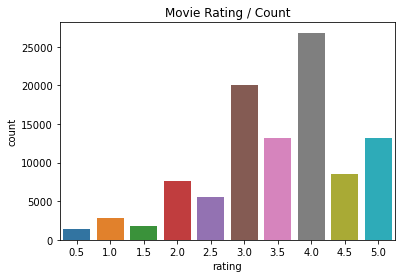

In [91]:
sns.countplot(ratings_df['rating'])
plt.title('Movie Rating / Count');
plt.savefig('Images/movie_rating')

I observe that the mean rating given by users is approximately `3.5` - `4` is the most common rating in the dataset.Most of the ratings in the dataset are above `3`.

Now, I will extract movie release year from movie title.

In [74]:
# Extracting release year from movie title
movies_df['year'] = movies_df['title'].str.extract('.*\((.*)\).*',expand = False)

In [75]:
movies_df['year'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '2005', '2006', '1902', nan, '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908', '2006–2007'], dtype=object)

 One value that is slightly off is '2006-2007' and the other is NaN. Let's check which movies do they correspond to:

In [76]:
movies_df[movies_df['year'] == "2006–2007"]

,movieId,title,genres,year
9518,171749,Death Note: Desu nôto (2006–2007),(no genres listed),2006–2007


In [77]:
# Changing this to 2007
movies_df['year'] = movies_df['year'].replace("2006–2007","2007")

In [78]:
# movies with no year information
movies_df[pd.isna(movies_df['year'])]

,movieId,title,genres,year
6059,40697,Babylon 5,Sci-Fi,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,NaN
9091,143410,Hyena Road,(no genres listed),NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),NaN
9179,149334,Nocturnal Animals,Drama|Thriller,NaN
9259,156605,Paterson,(no genres listed),NaN
9367,162414,Moonlight,Drama,NaN
9448,167570,The OA,(no genres listed),NaN
9514,171495,Cosmos,(no genres listed),NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),NaN


In [79]:
# As many of these don't have any genres as well, we will drop these rows
movies_df = movies_df.dropna(subset=['year'],how='any')

In [80]:
movies_df['year'] = movies_df['year'].astype(int)

In [81]:
movies_df['year'].describe()

count    9730.000000
mean     1994.614902
std        18.534692
min      1902.000000
25%      1988.000000
50%      1999.000000
75%      2008.000000
max      2018.000000
Name: year, dtype: float64

In [82]:
movies_df['year'].value_counts()

2002    311
2006    295
2001    294
2007    285
2000    283
       ... 
1917      1
1902      1
1903      1
1919      1
1908      1
Name: year, Length: 106, dtype: int64

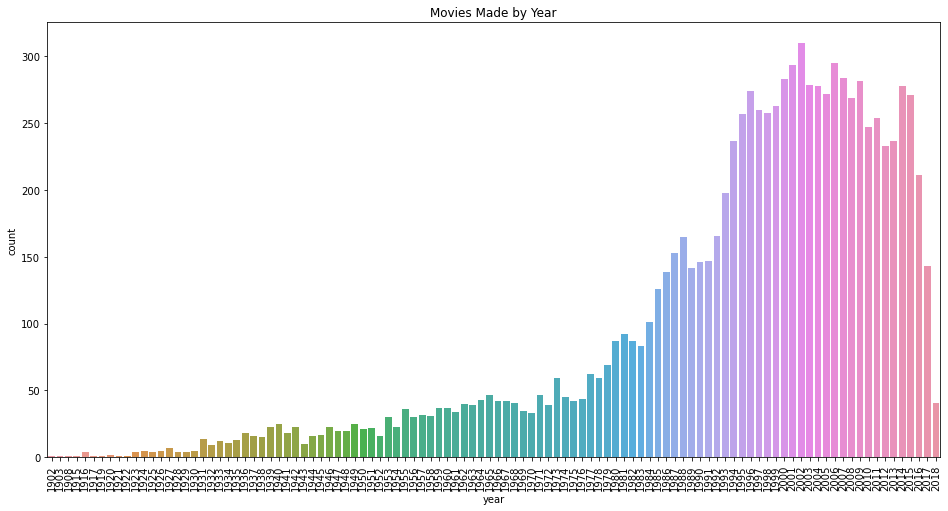

In [92]:
# number of movie in year
plt.figure(figsize=(16,8))
sns.countplot(movies_df['year']);
plt.xticks(rotation=90)
plt.title('Movies Made by Year')
#plt.savefig('Images/movie_year')

In this dataset, we have movies starting as early as 1902 and the latest movie is from 2018. The year with the maximum number of movies in this dataset is 2002 with 311 movies.

Now, let's look for any duplicate values.

In [84]:
# Validation check
print('Is there a duplicate value in a column movieId? Ans:',not movies_df["movieId"].is_unique)
print('Is there a duplicate value in a column title? Ans:',not movies_df["title"].is_unique)

movies_df[movies_df.duplicated(["title"], keep=False)]

Is there a duplicate value in a column movieId? Ans: False
Is there a duplicate value in a column title? Ans: True


,movieId,title,genres,year
650,838,Emma (1996),Comedy|Drama|Romance,1996
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller,1980
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller,2002
5601,26958,Emma (1996),Romance,1996
5854,32600,Eros (2004),Drama,2004
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,2005
6932,64997,War of the Worlds (2005),Action|Sci-Fi,2005
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller,2002
9135,147002,Eros (2004),Drama|Romance,2004
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller,1980


 There are 5 movies which are duplicated in our dataset.  They have the same title but different movieId. The problem is that the same movieId is then used in other tables as well. Let's replace the movieIds in each table.

In [85]:
movie_id_change = {838:26958, 2851:168358, 6003:144606,32600:147002,34048:64997}
movies_df['movieId'].replace(movie_id_change,inplace=True)
movies_df = movies_df.drop_duplicates(subset=["movieId","title"])

ratings_df['movieId'].replace(movie_id_change,inplace=True)
tags_df['movieId'].replace(movie_id_change,inplace=True)
links_df['movieId'].replace(movie_id_change,inplace=True)

In [86]:
# Validation check
print('Is there a duplicate value in a column movieId? Ans:',not movies_df["movieId"].is_unique)
print('Is there a duplicate value in a column title? Ans:',not movies_df["title"].is_unique)

Is there a duplicate value in a column movieId? Ans: False
Is there a duplicate value in a column title? Ans: False


Now let's extract individual genres from the genres column.But, first we need to replace a value in this column. Null value in genres column is given as `(no genres listed)`. 

In [87]:
import numpy as np

In [88]:
movies_df['genres'] = movies_df['genres'].replace('(no genres listed)', np.nan)
print('Number of missing values in genres column:',movies_df['genres'].isna().sum())

# dropping rows with missing genres
movies_df = movies_df.dropna(subset=['genres'],how='any')
movies_df = movies_df.reset_index(drop=True)

Number of missing values in genres column: 26


Now, I will use One-Hot Encoding and create columns for each genre

In [89]:
# Serepate the Genres Column and Encoding them with One-Hot Encoding
genres = []
for i in range(len(movies_df.genres)):
    for x in movies_df.genres[i].split('|'):
        if x not in genres:
            genres.append(x)
            
len(genres)
for x in genres:
    movies_df[x] = 0
for i in range(len(movies_df.genres)):
    for x in movies_df.genres[i].split('|'):
        movies_df[x][i]=1
        
#dropping the genres column as it's a no longer required
movies_df.drop(columns='genres', inplace=True)
movies_df.sort_index(inplace=True)
movies_df

,movieId,title,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,Toy Story (1995),1995,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9694,193581,Black Butler: Book of the Atlantic (2017),2017,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9695,193583,No Game No Life: Zero (2017),2017,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9696,193585,Flint (2017),2017,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9697,193587,Bungo Stray Dogs: Dead Apple (2018),2018,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Animation             611
Children              664
Comedy               3755
Fantasy               779
Romance              1593
Drama                4357
Action               1826
Crime                1198
Thriller             1890
Horror                978
Mystery               573
Sci-Fi                976
War                   382
Musical               334
Documentary           440
IMAX                  158
Western               167
Film-Noir              87


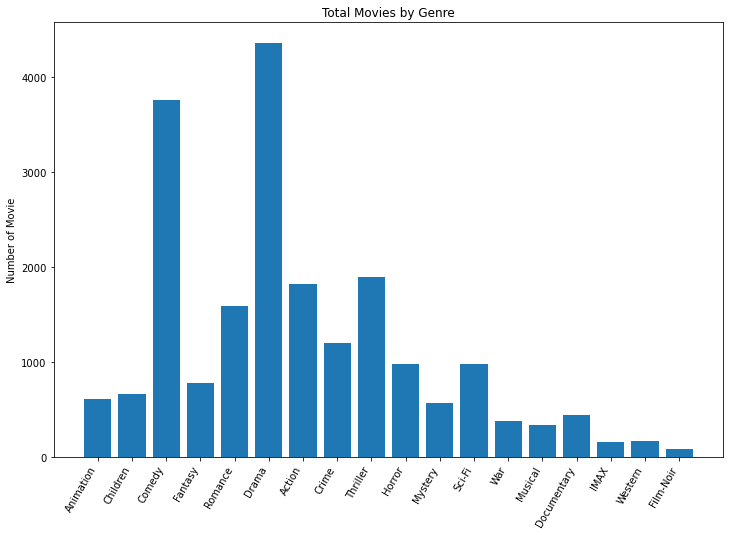

In [93]:
# plotting genres popularity
x = {}
for i in movies_df.columns[4:23]:
    x[i] = movies_df[i].sum()
    print(f"{i:<15}{x[i]:>10}")

plt.figure(figsize=(12,8))
plt.bar(height = x.values(), x=x.keys())
plt.xticks(rotation=60, ha='right')
plt.ylabel('Number of Movie')
plt.title('Total Movies by Genre')
#plt.savefig('Images/genres')
plt.show()

 Drama is the most popular genre with 4357 movies, followed by Comedy with 3755 movies.

 I will now merge the ratings and movie dataframe to get the average rating and num of ratings per movie.

In [95]:
# movies with no ratings receive 0 as their average rating
mean_rating = ratings_df.groupby('movieId').rating.mean().rename('mean rating')
num_rating = ratings_df.groupby('movieId').userId.count().rename('num rating')

movies_df = pd.merge(movies_df, mean_rating, how='left', on='movieId')
movies_df = pd.merge(movies_df, num_rating, how='left', on='movieId')

movies_df['mean rating'].fillna(0, inplace=True)
movies_df['num rating'].fillna(0, inplace=True)

movies_df[['title', 'mean rating', 'num rating']]

,title,mean rating,num rating
0,Toy Story (1995),3.920930,215.0
1,Jumanji (1995),3.431818,110.0
2,Grumpier Old Men (1995),3.259615,52.0
3,Waiting to Exhale (1995),2.357143,7.0
4,Father of the Bride Part II (1995),3.071429,49.0
...,...,...,...
9694,Black Butler: Book of the Atlantic (2017),4.000000,1.0
9695,No Game No Life: Zero (2017),3.500000,1.0
9696,Flint (2017),3.500000,1.0
9697,Bungo Stray Dogs: Dead Apple (2018),3.500000,1.0


Adding `mean rating` and `num rating` columns to our dataset would allow us to understand which movie is well loved or reviewed in our database. I will make use of this information in the following sections.

## Naive Recomendation Engine

This system, would use overall ratings and genres to recommend movies. This could work well in helping resolve the cold-start problem as well in the future.

As the first initial model, I can recommend the top 10 most popular movies(movies with most number of ratings) in our database to a new user.

In [96]:
movie_ratings = movies_df[['title', 'mean rating', 'num rating', ]]

In [97]:
movie_ratings.sort_values(by=['num rating'], ascending=False).head(10)

,title,mean rating,num rating
314,Forrest Gump (1994),4.164134,329.0
277,"Shawshank Redemption, The (1994)",4.429022,317.0
257,Pulp Fiction (1994),4.197068,307.0
510,"Silence of the Lambs, The (1991)",4.161290,279.0
1939,"Matrix, The (1999)",4.192446,278.0
224,Star Wars: Episode IV - A New Hope (1977),4.231076,251.0
418,Jurassic Park (1993),3.750000,238.0
97,Braveheart (1995),4.031646,237.0
507,Terminator 2: Judgment Day (1991),3.970982,224.0
461,Schindler's List (1993),4.225000,220.0


 As expected, all listed movies are internationally acclaimed hollywood classics.

 Now let's look at the top movies with the highest ratings in our database

In [98]:
# top 10 movies by its mean ratings
movie_ratings.sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
7598,Idiots and Angels (2008),5.0,1.0
8670,Stuart Little 3: Call of the Wild (2005),5.0,1.0
3110,Reform School Girls (1986),5.0,1.0
8501,"One I Love, The (2014)",5.0,1.0
8513,Laggies (2014),5.0,1.0
3081,"Monster Squad, The (1987)",5.0,1.0
8547,Crippled Avengers (Can que) (Return of the 5 D...,5.0,1.0
3067,Hollywood Shuffle (1987),5.0,1.0
8587,Watermark (2014),5.0,1.0
8606,Hellbenders (2012),5.0,1.0


 While these movies are rated quite high, they are not popular and only have 1 rating. This is not reliable information. I need to set a threshold of the minimum number of ratings a movie must have

In [99]:
#creating minimum number of ratings
minimum_num_ratings = 200
movie_ratings[movie_ratings['num rating']>minimum_num_ratings].sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
277,"Shawshank Redemption, The (1994)",4.429022,317.0
2226,Fight Club (1999),4.272936,218.0
46,"Usual Suspects, The (1995)",4.237745,204.0
224,Star Wars: Episode IV - A New Hope (1977),4.231076,251.0
461,Schindler's List (1993),4.225000,220.0
898,Star Wars: Episode V - The Empire Strikes Back...,4.215640,211.0
257,Pulp Fiction (1994),4.197068,307.0
1939,"Matrix, The (1999)",4.192446,278.0
314,Forrest Gump (1994),4.164134,329.0
510,"Silence of the Lambs, The (1991)",4.161290,279.0


 Now I see movies which are popular as well as loved by the users.

 Also, let's see if there is correlation between movies with higher number of ratings and movies with high average rating.

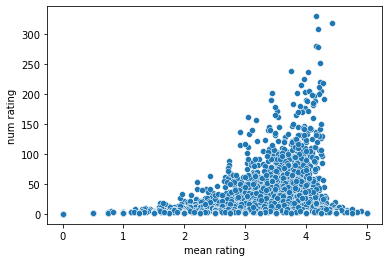

In [100]:
# mean rating and  total number of rating scatterplot
sns.scatterplot(data=movies_df, x='mean rating', y ='num rating');
plt.savefig('Images/mean_num_rating')

 As expected, movies that are good also receive more ratings.

 I can also use Genre information to further refine our recommendations.

 Suppose, there is a user who wants recommendation for an action movie, then:

In [48]:
# checking users that interest on action movie
user_genre = 'Action'
movie_ratings[movies_df[user_genre] == 1].sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
8547,Crippled Avengers (Can que) (Return of the 5 D...,5.0,1.0
7488,Faster (2010),5.0,1.0
8145,Justice League: Doom (2012),5.0,1.0
8973,Tokyo Tribe (2014),5.0,1.0
3759,Shogun Assassin (1980),5.0,1.0
3908,The Big Bus (1976),5.0,1.0
3110,Reform School Girls (1986),5.0,1.0
7900,Superman/Batman: Public Enemies (2009),5.0,1.0
1647,Knock Off (1998),5.0,1.0
4045,Galaxy of Terror (Quest) (1981),5.0,1.0


 Again setting a threshold on the minimum number of ratings

In [49]:
# setting minimum number of rating on users that interest on action movies
user_genre = 'Action'
minimum_num_ratings = 200
movie_ratings[(movies_df[user_genre] == 1) & (movies_df['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
2226,Fight Club (1999),4.272936,218.0
224,Star Wars: Episode IV - A New Hope (1977),4.231076,251.0
898,Star Wars: Episode V - The Empire Strikes Back...,4.215640,211.0
1939,"Matrix, The (1999)",4.192446,278.0
97,Braveheart (1995),4.031646,237.0
507,Terminator 2: Judgment Day (1991),3.970982,224.0
418,Jurassic Park (1993),3.750000,238.0
615,Independence Day (a.k.a. ID4) (1996),3.445545,202.0


## Naive Recomendation Engine (New User)

Let's combine all the techniques that we used above to build a basic recomendation engine:

  1. If no information is available for the user, then recommend movies rated more than default threshold of 100 times with the highest ratings.
  2. If user sets a threshold, then recommend movies rated more than threshold times with the highest ratings.
  3. If genre is presented, then recommend movies from that genre rated more than threshold times with the highest ratings.

In [50]:
def naive_recommendation(threshold,fav_genre):
    
    minimum_num_ratings = threshold
    if fav_genre == 'All':
        result = movie_ratings[(movies_df['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)    
    else:
        result = movie_ratings[(movies_df[fav_genre] == 1) & (movies_df['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)
    
    print('\n\nThese are the recommendations for the users with the following filters')
    print('Minimum number of ratings:',threshold)
    print("User's choice of genre:",fav_genre)
    display(result)

    
genres = ['All',
          'Animation',
          'Children',
          'Comedy',
          'Fantasy',
          'Romance',
          'Drama',
          'Action',
          'Crime',
          'Thriller',
          'Horror',
          'Mystery',
          'Sci-Fi',
          'War',
          'Musical',
          'Documentary',
          'IMAX',
          'Western',
          'Film-Noir'
         ]
w = interactive(naive_recommendation, threshold=widgets.IntSlider(min=0, max=200, value=100, step=5),
                       fav_genre=widgets.Dropdown(options=genres, description="Genre")
               )
display(w)

interactive(children=(IntSlider(value=100, description='threshold', max=200, step=5), Dropdown(description='Ge…

## Colloborative Filtering

### Item based Using Correlation

I will now design a recomendation engine that uses the correlation between the ratings assined to different movies, in order to find the similarity between the movies.

Let's create a matrix where each column is a movie name and esch row contains the rating assigned by a specific user to that movie.

In [51]:
# merging ratings and movies data
df = pd.merge(ratings_df, movies_df, how='left', on = 'movieId')
# creating matrix
movie_user_matrix = df.pivot_table(index='userId', columns='title', values='rating')
movie_user_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


 As most users will only review a few movies, majority of the values in this matrix will be NaN.

 Now, let's consider that you wish look at movies that are similar to Lion King.

In [52]:
movie_name = "Lion King, The (1994)"
movie_ratings_df = movie_user_matrix[movie_name]
movie_ratings_df.head()

userId
1    NaN
2    NaN
3    NaN
4    NaN
5    3.0
Name: Lion King, The (1994), dtype: float64

 Retrieving movies where the ratings are extremely correlated with Lion King:

In [53]:
correlation = movie_user_matrix.corrwith(movie_ratings_df)
similar_movies = pd.DataFrame(correlation, columns=['Correlation'])
# removing nulls
similar_movies.dropna(inplace=True)

# Top 10 highly correlated movies with Lion King
similar_movies.sort_values('Correlation', ascending=False).head(10)

,Correlation
title,
Despicable Me 3 (2017),1.0
"Sound of Thunder, A (2005)",1.0
Damsels in Distress (2011),1.0
Danny Deckchair (2003),1.0
Joy (2015),1.0
Only the Lonely (1991),1.0
Soul Plane (2004),1.0
Jobs (2013),1.0
"Ordet (Word, The) (1955)",1.0


 Some of these ratings make sense, but some don't. Let's bring number of ratings in picture here. I will set a threshold of 50 to the number of ratings here:

In [54]:
similar_movies = pd.merge(similar_movies, movies_df[['title','num rating']].drop_duplicates(), left_index=True, right_on='title')
similar_movies.set_index('title', inplace=True)

# Top 10 highly correlated movies with Lion King that have been rated more than 50 times
threshold = 50
similar_movies.sort_values('Correlation', ascending=False)[similar_movies['num rating']>threshold].head(10)

,Correlation,num rating
title,,
"Lion King, The (1994)",1.000000,172.0
Guardians of the Galaxy (2014),0.673887,59.0
X2: X-Men United (2003),0.596938,76.0
Aladdin (1992),0.591660,183.0
While You Were Sleeping (1995),0.565303,98.0
Casper (1995),0.555249,62.0
Hook (1991),0.541501,53.0
Grumpier Old Men (1995),0.541416,52.0
Predator (1987),0.533184,61.0


 While there are some movies like Aladdin that do make sense here, most don't. This means that maybe we need to improve our model or add more information to help the model.

## User Based Collabrative Filtering using surprise library

For our next few models, we will utilize the `surprise` library which allows us to build complex recommendation engine pipelines effortlessly.I will try out a total of five algoritms.

First tree are KNN based algoritms:

   - `KNNBasic`
   - `KNNWithMeans`
   - `KNNWithZone`
   
Next two are matrix factorization based algoritms:

   - `SVD`
   - `SVDpp`
   
I will evaluate top models from each list and then do grid search on them to search for the best hyperparameters.

But first, I will convert our dataset into something that the surprise library can understand.

In [55]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD, SVDpp
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNWithZScore
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [56]:
# read in values as Surprise dataset
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings_df, reader)

#generating a trainset
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9719


In [48]:
# knn algoritms
cv_knn_basic = cross_validate(KNNBasic(), data, cv=5, n_jobs=5, verbose=True)
cv_knn_means = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=True)
cv_knn_z = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9471  0.9475  0.9508  0.9434  0.9453  0.9468  0.0025  
MAE (testset)     0.7277  0.7253  0.7271  0.7237  0.7247  0.7257  0.0015  
Fit time          1.01    1.01    0.84    1.10    1.12    1.02    0.10    
Test time         8.08    8.69    5.69    8.61    7.91    7.80    1.09    
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8996  0.8988  0.8952  0.9065  0.8875  0.8975  0.0062  
MAE (testset)     0.6878  0.6860  0.6815  0.6915  0.6808  0.6855  0.0040  
Fit time          0.78    0.95    1.06    1.14    1.10    1.01    0.13    
Test time         10.96   9.67    8.03    10.11   8.64    9.48    1.04    
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean  

In [ ]:
# matrix factorization algoritms
cv_svd = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=True)
cv_svd_pp = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8758  0.8675  0.8859  0.8734  0.8688  0.8743  0.0065  
MAE (testset)     0.6735  0.6664  0.6810  0.6720  0.6678  0.6721  0.0052  
Fit time          26.96   32.78   24.68   27.51   30.04   28.39   2.78    
Test time         0.65    0.47    0.75    0.50    0.57    0.59    0.10    


In [ ]:
# Printing out the results for these algoritms
# run time approximately 18min.
print('Evaluation Results:')
print('Algoritm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(cv_knn_basic['test_rmse'].mean(), 4), '\t\t', round(cv_knn_basic['test_mae'].mean(), 4))
print('KNN Means', '\t', round(cv_knn_means['test_rmse'].mean(), 4), '\t\t', round(cv_knn_means['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(cv_knn_z['test_rmse'].mean(), 4), '\t', round(cv_knn_z['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(cv_svd['test_rmse'].mean(), 4), '\t', round(cv_svd['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(cv_svd_pp['test_rmse'].mean(), 4), '\t', round(cv_svd_pp['test_mae'].mean(), 4))

I chiose two standard errors as our evaluation metrics:

- **Mean Absolute Error(MAE)** computes the avarage of all the absolute value differences between the true and the predicted rating.
- **Root Mean Square Error(RMSE)** computes the mean value of all the differences squared between the true and the predicted ratings and then proceeds to calculate the square root out of the result.

For both of these metrics, lower the error better the accuracy.

An avarage MAE of 0.6713 for SVD indicates an avarage absolute error of 0.6713 between the true and predicted ratings. I will try to reduce this error further by tuning hyperparameters.

In [ ]:
# Plotting graphs for comparing accuracy of each algo
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp',]
all_algos_cv = [cv_knn_basic, cv_knn_means, cv_knn_z, cv_svd, cv_svd_pp]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

# RMSE graph
plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

# MAE graph
plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

 Both the Matrix Factorization algorithms seem to do much better for both the metrics. KNN Means and KNN ZScore are also okay as compared to KNN Basic.

 Selecting top models from each algorithm type: **KNN Means** and **SVDpp**

## KNN Based Algorithms

I will now optimize on these two models. Let's start with KNN Means. We will optimize two hyperparameters: `k(numver of neighbors` and `distance metric`.First, I search for optimal `k` between 5 and 100.

In [ ]:
param_grid = {'k': [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]}

gs_knn_means = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
gs_knn_means.fit(data)

y1 = gs_knn_means.cv_results['mean_test_rmse']
y2 = gs_knn_means.cv_results['mean_test_mae']

In [ ]:
# plotting accuracies for comparison
plt.figure(figsize = (18, 15))

x = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNWithMeans', color='lightcoral', marker='o')
plt.xlabel('K Neighbors', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNWithMeans', color='lightcoral', marker='o')
plt.xlabel('K Neighbors', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()

 From the plots above optimal `k` is found at 20. Now, we will look for the best distance metric out of these four: `cosine`, `pearson`, `msd` and `pearson baseline`.

In [ ]:
# comparing distance matrix

knn_means_cosine = cross_validate(KNNWithMeans(k=20, sim_options={'name':'cosine'}), data, cv=5, n_jobs=5, verbose=True)
knn_means_pearson = cross_validate(KNNWithMeans(k=20, sim_options={'name':'pearson'}), data, cv=5, n_jobs=5, verbose=True)
knn_means_msd = cross_validate(KNNWithMeans(k=20, sim_options={'name':'msd'}), data, cv=5, n_jobs=5, verbose=True)
knn_means_pearson_baseline = cross_validate(KNNWithMeans(k=20, sim_options={'name':'pearson_baseline'}), data, cv=5, n_jobs=5, verbose=True)


x_distance = ['cosine', 'pearson', 'msd', 'pearson_baseline',]
all_distances_cv = [knn_means_cosine, knn_means_pearson, knn_means_msd, knn_means_pearson_baseline]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_distances_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_distances_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Distance Metrics on RMSE', loc='center', fontsize=15)
plt.plot(x_distance, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Distance Metrics', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Distance Metrics on MAE', loc='center', fontsize=15)
plt.plot(x_distance, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Distance Metrics', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

Based on our hyperparameter tuning, the best KNN based model that we found out was:

KNN-Means with k=20 and pearson_baseline similarity

 - **RMSE**: 0.8984
 - **MAE** : 0.6807

## Matrix Factorization Based Algorithms

While SVDpp had the better performance in terms of error rate, it is very time consuming to train. A grid search on SVDpp lasts many days. So, I chose to optimize the SVD model for number of epochs, learning rate and regularization using grid search.

In [ ]:
#Prarameter space
# run time approximately 
svd_param_grid = {'n_epochs': [20, 25, 30, 40, 50],
                  'lr_all': [0.007, 0.009, 0.01, 0.02],
                  'reg_all': [0.02, 0.04, 0.1, 0.2]}

gs_svd_pp = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
gs_svd_pp.fit(data)

In [ ]:
print('Best value for SVDpp  -RMSE:', round(gs_svd_pp.best_score['rmse'], 4), '; MAE:', round(gs_svd_pp.best_score['mae'], 4))
print('Optimal params RMSE =', gs_svd_pp.best_params['rmse'])
print('optimal params MAE =', gs_svd_pp.best_params['mae'])

Based on our hyperparameter tuning, the best Matrix factorization based model that we found out was:

SVDpp with number of epochs = 50 , learning rate = 0.02 , and regularization = 0.1

- **RMSE:** 0.8507
- **MAE:** 0.6517

### Predictions

Let's see the model in action to check if it's working as expected or not. But, first I need to fit both the final models on training set.

In [ ]:
dataset = data.build_full_trainset()
final_knn_model = KNNWithMeans(k=20, sim_options={'name': 'pearson_baseline'})
final_knn_model.fit(dataset)

In [ ]:
final_svd_model = SVD(n_epochs=50, lr_all=0.02, reg_all=0.1)
final_svd_model.fit(dataset)

Now that I have a trained model, I can use it to predict the rating a user would assign to a movie given an ID for the user (UID) and an ID for the item/movie(IID)

I am picking user with `userID`=610.This user really liked the movie `Toy Story (1995)`. We will now try to predict the rating that this user will give the movie `Toy Story 3 (2010)`.

In [ ]:
# Showing rating given by this user for Toy Story (1995)
# userId: 610
# movieId: 1 for Toy Story (1995)

df[(df['userId'] == 610) & (df['movieId'] == 1)][['userId', 'movieId', 'rating', 'title']]

Toy Story 3 (2010) was a well loved movie. We would assume that a user who really liked Toy Story 1 would really this movie. So, we hope that the expected rating given by each of these models is quite high.

In [ ]:
# KNN Model prediction on iid: 78499 - Toy Story 3 (2010)
final_knn_model.predict(uid=610, iid=78499)

In [ ]:
# SVD Model prediction on iid: 78499 - Toy Story 3 (2010)
final_svd_model.predict(uid=610, iid=78499)

The field `est` indicates the estimated movie rating for this specific user.

We see that both the models give a strong positive rating for this specifiv movie and user. We also ran random experiments with a couple dozen user-movie pairs and received results that are consistent with our expectation.

We choose to move forward with the SVD model as it has a lower MAE and RMSE value.

We will now design a generic function which will take in a user id, then calculate expected ratings for all the movies and return the top 5 movies with the highest expected ratings.

We will also filter out movies already viewed by the user and provide functionality to mention preferred genre and minimum number of ratings.

In [ ]:
def get_movie_recommendations(user_id, preferred_genre = 'all',minimum_num_ratings=50):
    
    new_df = df.copy()
    
    # filtering out by genre
    if preferred_genre !='all':
        new_df = new_df[new_df[preferred_genre]==1]
    
    # filtering out by number of ratings
    new_df = new_df[new_df['num rating']>=minimum_num_ratings]
    
    # filtering out all movies already rated by user
    movies_already_watched = set(new_df[new_df['userId']==user_id].movieId.values)
    new_df= new_df[~new_df['movieId'].isin(movies_already_watched)]
    
    # finding expected ratings for all remaining movies in the dataset
    all_movie_ids = set(new_df['movieId'].values)
    all_movie_ratings = []
    
    for i in all_movie_ids:
        expected_rating = final_svd_model.predict(uid=user_id, iid=i).est
        all_movie_ratings.append((i,round(expected_rating,1)))
        
    # extracting top five movies by expected rating
    expected_df = pd.DataFrame(all_movie_ratings, columns=['movieId','Expected Rating'])    
    result_df = pd.merge(expected_df, movies_df[['movieId','title','num rating']],on='movieId')
    result_df = result_df.sort_values(['Expected Rating','num rating'],ascending=[False,False])
    
    return result_df.head()

In [ ]:
# receiving movie ratings for a given user id
get_movie_recommendations(1)

Everything seems to be in place now. The above function utilizes both the model plus some filters to give some truly amazing movie recommendations.

Minimum number of ratings is an interesting filter because if we set it too high, we only get classics and we won't find any new movies. Whereas if we set it too low, we can get virtually any movie. We like to think of it as an exploration risk parameter. Set value for it by asking yourself the following question: **How much risk are you willing to take to find new movies?**

# Final Recomendation Engine

The final recommendation engine will be a hybrid between two models that we saw in this file: the final SVD model and the naive recommendation engine.

 1. The naive recommendation engine is used to solve the **cold-start** problem for users who are new and have no ratings in the dataset.
 2. If the userId is in the dataset, then we will use the final model with filters that we saw in the previous section.

In [ ]:
def hybrid_recommendation_engine(user_id='new',preferred_genre='all',minimum_num_ratings=50):
    
    if user_id=='new':
        if preferred_genre == 'all':
            result = movie_ratings[(movies_df['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)    
        else:
            result = movie_ratings[(movies_df[preferred_genre] == 1) & (movies_df['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)

    else:
        new_df = df.copy()
    
        # filtering out by genre
        if preferred_genre !='all':
            new_df = new_df[new_df[preferred_genre]==1]

        # filtering out by number of ratings
        new_df = new_df[new_df['num rating']>=minimum_num_ratings]

        # filtering out all movies already rated by user
        movies_already_watched = set(new_df[new_df['userId']==user_id].movieId.values)
        new_df= new_df[~new_df['movieId'].isin(movies_already_watched)]

        # finding expected ratings for all remaining movies in the dataset
        all_movie_ids = set(new_df['movieId'].values)
        all_movie_ratings = []

        for i in all_movie_ids:
            expected_rating = final_svd_model.predict(uid=user_id, iid=i).est
            all_movie_ratings.append((i,round(expected_rating,1)))

        # extracting top five movies by expected rating
        expected_df = pd.DataFrame(all_movie_ratings, columns=['movieId','Expected Rating'])    
        result = pd.merge(expected_df, movies_df[['movieId','title','num rating']],on='movieId')
        result = result.sort_values(['Expected Rating','num rating'],ascending=[False,False])
        result = result.head()
    
    
    print('\n\nThese are the recommendations for the users with the following filters')
    print('User id:',user_id)
    print('Minimum number of ratings:',minimum_num_ratings)
    print("User's choice of genre:", preferred_genre)
    display(result)


        
genres = ['all',
          'Animation',
          'Children',
          'Comedy',
          'Fantasy',
          'Romance',
          'Drama',
          'Action',
          'Crime',
          'Thriller',
          'Horror',
          'Mystery',
          'Sci-Fi',
          'War',
          'Musical',
          'Documentary',
          'IMAX',
          'Western',
          'Film-Noir'
         ]
all_userids = ['new'] + list(set(df.userId.values))
w = interactive(hybrid_recommendation_engine,
                user_id=widgets.Dropdown(options=all_userids, description="user_id"),
                minimum_num_ratings=widgets.IntSlider(min=0, max=200, value=100, step=5),
                preferred_genre=widgets.Dropdown(options=genres, description="Genre")
               )
display(w)

The hybrid recommendation engine allows us to effectively solve the cold-start problem and provide meaningful movie recommendations to all users.

Kindly try out the dashboard and let us know what you think. I have been using this for movie night recommendations.

# Conclusion

I analyzed a variety of movie recommendation systems on the famous MovieLens database. I started with a naive recommendation engine which did not make any assumptions about the user and provided general recommendations based upon movie popularity or the average ratings given by other users in the database.

I then progressed to some collaborative filtering based engines which try to find similar movies or users to make their predictions. After assessing models on two metrics, `RMSE` and `MAE`, we designed a `SVD` model and also tuned it for multiple hyperparameters.

Finally, I made a hybrid system of our naive recommendation engine and the SVD model to help resolve the cold-start problem. We added filtering options for genre and minimum number of ratings to give users some control over these recommendations.

# Future Work

There is a lot of potential for future work in this project.

To begin with, I would like to add functionality in our final dashboard to allow new users to rate some movies and then to utilize that information to improve our recommendation system.

I also couldn't make use of `tag` information in this part of the analysis. We would like to make word embeddings from tags and other meta information about the movie and use it in our model.

I can also make use of the `links` dataset and scrape more information about each movie from the internet. This could involve significant features like cast, director, plot, etc.